# MTA Subway Origin-Destination Ridership Estimate: 2023
Author: Mark Bauer  
New York State Open Data: https://data.ny.gov/Transportation/MTA-Subway-Origin-Destination-Ridership-Estimate-2/uhf3-t34z/about_data

# Introduction
The goal of this project is to analyze and visualize basic statistics from the MTA 2023 Subway Origin-Destination Ridership Estimate dataset. 

Description about the dataset from the data dictionary:
>This dataset provides an estimate of subway travel patterns based on scaled-up OMNY and MetroCard
return tap and swipe data for 2023. It will provide estimated passenger volumes for all populated origindestination (OD) pairs aggregated by month, day of the week, and hour of day. It also provides the
name, ID, and approximate latitude and longitude of the origin and destination subway complexes.

Additionally, the MTA wrote an article introducing the dataset that I've found useful and informative. In particular, how the dataset is aggregated. For example: **The format of this aggregated dataset allows users to understand for “an average 9 a.m. hour during the month of May,” roughly how many people travelled between two subway complexes.**
> **About the data**  
Let’s talk a bit more about the data. This dataset is based off of the ‘Destination Inference’ step of our ridership model, which we detailed in a [previous blog post](https://new.mta.info/article/where-everybody-subway-going). As that post outlines, the basis of this model is the assumption that a subway trip’s destination is the station the rider next swipes/taps at. If a MetroCard swipes into Bowling Green at 9:15 a.m., and then that same MetroCard swipes into the 103 St stop in East Harlem later that afternoon, we make the imperfect (but pretty good) inference that this 9:15 a.m. trip traveled from Bowling Green to 103 St. These “linked trips” are what form the basis of our understanding of how riders travel across the system (Note 1).
>
>In this Subway Origin-Destination (OD) dataset, we’ve taken these assigned destinations generated by our destination inference process and aggregated them by origin-destination station complex pair and hour of day. These totals are then further aggregated by averaging over a calendar month. Removing personally identifying information, like MetroCard ID numbers, and aggregating ridership data over a calendar month is done to protect the privacy of MTA riders by preventing the association of a single MetroCard swipe or subway trip to a specific person or hour. The format of this aggregated dataset allows users to understand for “an average 9 a.m. hour during the month of May,” roughly how many people travelled between two subway complexes.
>
>It’s important to keep a few things in mind when using this data: 
>
>Because this data is the result of a modeling process, the ridership numbers for each origin-destination pair are estimates, not exact values. This modeling process, as well as the monthly aggregation, results in fractional ridership values—we’ve intentionally left ridership estimates as decimals to reflect the uncertainty inherent in this dataset. 
Because this data represents a monthly average, users should be mindful that holidays, construction, or other important events that take place during a given month might impact ridership estimates. 
Since the modeling process only looks at subway station entries, we can’t quantify how many of these trips truly started and ended at these subway station complexes and how many may have included a transfer from or to another mode of transit (e.g. a bus) at either or both ends. 
When using the data to look at arrivals to a subway station, users should note that the timestamp for each OD pair is rounded down to the nearest hour of the entry swipe (or tap) and does not account for the travel time between the entry swipe and arrival at the destination (Note 2).

Source: [Introducing the Subway Origin-Destination Ridership dataset](https://new.mta.info/article/introducing-subway-origin-destination-ridership-dataset)

![dataset-screenshot](images/dataset-screenshot.png)

Source: https://data.ny.gov/Transportation/MTA-Subway-Origin-Destination-Ridership-Estimate-2/uhf3-t34z/about_data

# Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import duckdb
import urllib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print('printing packages and versions:\n')

%reload_ext watermark
%watermark -v -p pandas,geopandas,duckdb,urllib.request,seaborn,matplotlib

printing packages and versions:

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

pandas        : 1.5.1
geopandas     : 0.12.1
duckdb        : 1.0.0
urllib.request: 3.11
seaborn       : 0.12.1
matplotlib    : 3.6.2



In [3]:
# list files
%ls

LICENSE
MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf
MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf
README.md
data-exporter.py
export-log.txt
figures/
images/
subway-trips.db
subway-trips.ipynb


In [4]:
# list file sizes
!du -sh * | sort -rh

2.5G	subway-trips.db
2.7M	figures
1.8M	subway-trips.ipynb
1.6M	images
192K	MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf
128K	MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf
 28K	README.md
 16K	export-log.txt
4.0K	data-exporter.py
4.0K	LICENSE


# Download dataset overview and data dictionary files

In [5]:
# download dataset overview
url = 'https://data.ny.gov/api/views/uhf3-t34z/files/5be7cd3f-8f71-41a1-9923-a43f6dcb6276?download=true&filename=MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf'
urllib.request.urlretrieve(url, 'MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf')

# download data dictionary
url = 'https://data.ny.gov/api/views/uhf3-t34z/files/846e53a2-6555-4655-80b6-07fb55f234f1?download=true&filename=MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf'
urllib.request.urlretrieve(url, 'MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf')

# sanity check
%ls

LICENSE
MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf
MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf
README.md
data-exporter.py
export-log.txt
figures/
images/
subway-trips.db
subway-trips.ipynb


# Create a DuckDB database instance
We will mainly use [DuckDB](https://duckdb.org/) for this analysis, which is an in-process SQL OLAP database management system. I love it, and you might too.

In [6]:
# create a DuckDB database instance
con = duckdb.connect("subway-trips.db")

print(f"DuckDB object: {con}")

DuckDB object: <duckdb.duckdb.DuckDBPyConnection object at 0x1683be7f0>


# Preview data
Notice how fast DuckDB counts rows on this file.

In [7]:
%%time

# count rows
con.sql("SELECT COUNT(*) AS count_rows FROM trips").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│  115731896 │
└────────────┘

CPU times: user 98.6 ms, sys: 37.2 ms, total: 136 ms
Wall time: 27.4 ms


In [8]:
%%time

# preview data
con.sql("SELECT * FROM trips LIMIT 5").df()

CPU times: user 11 ms, sys: 27.9 ms, total: 38.9 ms
Wall time: 10.7 ms


,year,month,day_of_week,hour_of_day,timestamp,origin_station_complex_id,origin_station_complex_name,origin_latitude,origin_longitude,destination_station_complex_id,destination_station_complex_name,destination_latitude,destination_longitude,estimated_average_ridership,origin_point,destination_point
0,2023,1,Monday,1,2023-01-02T01:00:00.000,169,"Canal St (A,C,E)",40.720824,-74.005229,623,"Canal St (J,N,Q,R,W,Z,6)",40.718701,-74.000580,0.8476,POINT (-74.005229 40.720824),POINT (-74.00058 40.718701)
1,2023,1,Monday,1,2023-01-02T01:00:00.000,268,"65 St (M,R)",40.749669,-73.898453,451,Junction Blvd (7),40.749145,-73.869527,0.2000,POINT (-73.898453 40.749669),POINT (-73.869527 40.749145)
2,2023,1,Monday,1,2023-01-02T01:00:00.000,407,Astor Pl (6),40.730054,-73.991070,291,Clinton-Washington Avs (G),40.688089,-73.966839,0.2400,POINT (-73.99107 40.730054),POINT (-73.966839 40.688089)
3,2023,1,Monday,1,2023-01-02T01:00:00.000,604,"161 St-Yankee Stadium (B,D,4)",40.827950,-73.925741,76,Bay Pkwy (N),40.611815,-73.981848,0.2000,POINT (-73.925741 40.82795),POINT (-73.981848 40.611815)
4,2023,1,Monday,1,2023-01-02T01:00:00.000,630,"Myrtle-Wyckoff Avs (L,M)",40.699622,-73.911986,110,Forest Av (M),40.704423,-73.903077,0.6118,POINT (-73.911986 40.699622),POINT (-73.903077 40.704423)


In [9]:
# examine columns and column types
con.sql("DESCRIBE trips").show()

┌──────────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│           column_name            │ column_type │  null   │   key   │ default │  extra  │
│             varchar              │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ year                             │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ month                            │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ day_of_week                      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ hour_of_day                      │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ timestamp                        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ origin_station_complex_id        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ origin_station_complex_name      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │

Notice again how fast DuckDB is with full table summary statistics.

In [10]:
%%time

# examine approx. column statistics
summarize_df = con.sql("SUMMARIZE trips").df()

summarize_df

CPU times: user 7min 10s, sys: 3.82 s, total: 7min 14s
Wall time: 59.1 s


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,year,BIGINT,2023,2023,1,2023.0,0.0,2023,2023,2023,115731896,0.0
1,month,BIGINT,1,12,12,6.519164405636282,3.4324430452069934,4,6,10,115731896,0.0
2,day_of_week,VARCHAR,Friday,Wednesday,7,None,None,None,None,None,115731896,0.0
3,hour_of_day,BIGINT,0,23,24,13.121365288960616,5.706875745089826,9,14,18,115731896,0.0
4,timestamp,VARCHAR,2023-01-02T00:00:00.000,2023-12-10T23:00:00.000,2019,None,None,None,None,None,115731896,0.0
5,origin_station_complex_id,BIGINT,1,636,425,297.4252586858164,181.87919890339504,152,289,417,115731896,0.0
6,origin_station_complex_name,VARCHAR,1 Av (L),Zerega Av (6),425,None,None,None,None,None,115731896,0.0
7,origin_latitude,DOUBLE,40.576127,40.903125,434,40.734222540752796,0.0700467317057817,40.686417931125774,40.73259673117439,40.7751303788472,115731896,0.0
8,origin_longitude,DOUBLE,-74.074835,-73.755405,431,-73.94421252522619,0.05266772362348141,-73.98597110904898,-73.954903885735,-73.91202654709092,115731896,0.0
9,destination_station_complex_id,BIGINT,1,636,425,296.11294271891995,180.74255805917008,153,289,415,115731896,0.0


In [11]:
# number of unique stations per origin/destination trip
con.sql("""
    SELECT
        COUNT(DISTINCT origin_station_complex_id) AS count_origin_stations,
        COUNT(DISTINCT destination_station_complex_id) AS count_destination_stations
    FROM trips
""").df()

,count_origin_stations,count_destination_stations
0,425,425


In [12]:
# count of each origin and destination subway combination
con.sql("""
    WITH count_trips AS (
        SELECT
            origin_station_complex_name,
            destination_station_complex_name,
            COUNT(*) AS count_trips
        FROM trips
        GROUP BY ALL
    )
        
   SELECT
       COUNT(*) count_trip_combinations
    FROM count_trips     
""").df()

,count_trip_combinations
0,178032


# Peak Hourly Travel Times and Trends
This dataset is aggregated by day of the week and hour in a given month, so let's analyze average hourly ridership first. Note: For the figures below, we retrieve only estimated average hourly ridership greater than or equal to 25. 

In [13]:
peak_hours = con.sql("""
        SELECT
            month,
            hour_of_day,
            day_of_week,
            estimated_average_ridership
        FROM trips
        WHERE estimated_average_ridership >= 25
""").df()

peak_hours

,month,hour_of_day,day_of_week,estimated_average_ridership
0,1,13,Monday,52.9884
1,1,13,Monday,26.4760
2,1,13,Monday,32.6926
3,1,13,Monday,36.8356
4,1,13,Monday,27.6336
...,...,...,...,...
1232840,12,12,Sunday,31.8890
1232841,12,12,Sunday,113.3570
1232842,12,12,Sunday,44.0028
1232843,12,12,Sunday,30.2128


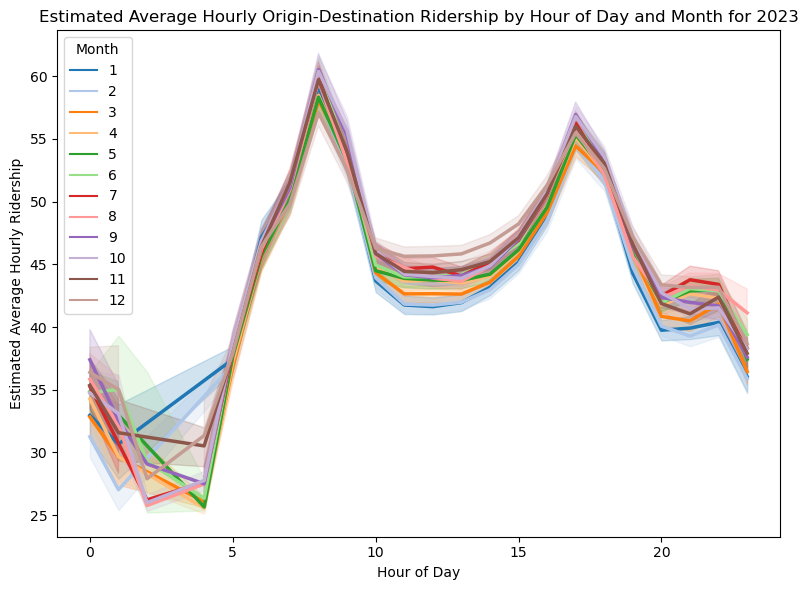

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=peak_hours,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='month',
    palette=sns.color_palette('tab20', n_colors=12),
    linewidth=2.5,
    ax=ax
)

ax.get_legend().set_title('Month')

plt.title('Estimated Average Hourly Origin-Destination Ridership by Hour of Day and Month for 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout()   
plt.savefig('figures/hour-month.png', dpi=200, bbox_inches='tight')

Figure 1: Estimated Average Hourly Origin-Destination Ridership by Hour of Day and Month for 2023. The figure displays the average hourly ridership across all trips and days of the week. The error bands represent the 95% confidence interval. Hourly ridership values below 25 have been excluded from the display.

In [15]:
peak_hours.loc[~peak_hours['day_of_week'].isin(['Saturday', 'Sunday']), 'weekday_flag'] = 'Weekday'
peak_hours['weekday_flag'] = peak_hours['weekday_flag'].fillna('Weekend')

peak_hours

,month,hour_of_day,day_of_week,estimated_average_ridership,weekday_flag
0,1,13,Monday,52.9884,Weekday
1,1,13,Monday,26.4760,Weekday
2,1,13,Monday,32.6926,Weekday
3,1,13,Monday,36.8356,Weekday
4,1,13,Monday,27.6336,Weekday
...,...,...,...,...,...
1232840,12,12,Sunday,31.8890,Weekend
1232841,12,12,Sunday,113.3570,Weekend
1232842,12,12,Sunday,44.0028,Weekend
1232843,12,12,Sunday,30.2128,Weekend


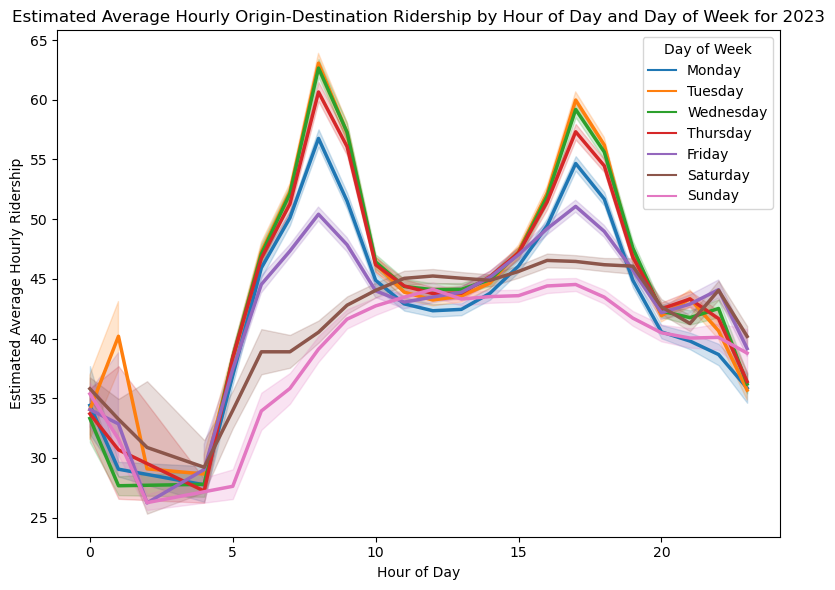

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=peak_hours,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='day_of_week',
    palette="tab10",
    linewidth=2.5,
    ax=ax
)

ax.get_legend().set_title('Day of Week')

plt.title('Estimated Average Hourly Origin-Destination Ridership by Hour of Day and Day of Week for 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout()   
plt.savefig('figures/hour-dayofweek.png', dpi=200, bbox_inches='tight')

Figure 2: Estimated Average Hourly Origin-Destination Ridership by Hour of Day and Day of Week for 2023. The figure displays the average hourly ridership across all trips and months. The error bands represent the 95% confidence interval. Hourly ridership values below 25 have been excluded from the display.

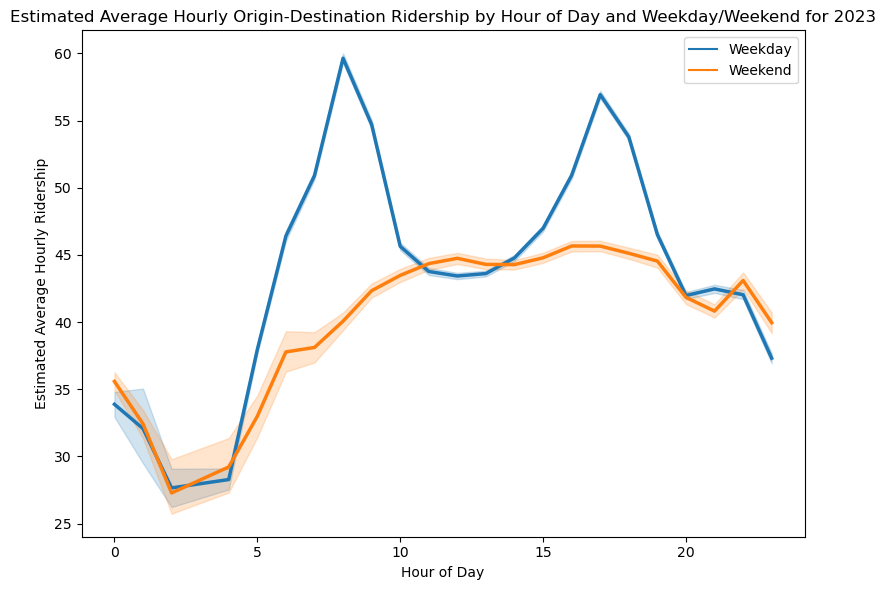

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=peak_hours,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='weekday_flag',
    palette="tab10",
    linewidth=2.5,
    ax=ax
)

ax.get_legend().set_title('')

plt.title('Estimated Average Hourly Origin-Destination Ridership by Hour of Day and Weekday/Weekend for 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout()   
plt.savefig('figures/hour-weekends.png', dpi=200, bbox_inches='tight')

Figure 3: Estimated Average Hourly Origin-Destination Ridership by Hour of Day and Weekday/Weekend for 2023. The figure displays the average hourly ridership across all trips, months and days within weekday and weekend categories. The error bands represent the 95% confidence interval. Hourly ridership values below 25 have been excluded from the display.

In [18]:
peak_hours.loc[peak_hours['month'].isin([1, 2, 3]), 'quarter'] = 'Q1'
peak_hours.loc[peak_hours['month'].isin([4, 5, 6]), 'quarter'] = 'Q2'
peak_hours.loc[peak_hours['month'].isin([7, 8, 9]), 'quarter'] = 'Q3'
peak_hours.loc[peak_hours['month'].isin([10, 11, 12]), 'quarter'] = 'Q4'

peak_hours

,month,hour_of_day,day_of_week,estimated_average_ridership,weekday_flag,quarter
0,1,13,Monday,52.9884,Weekday,Q1
1,1,13,Monday,26.4760,Weekday,Q1
2,1,13,Monday,32.6926,Weekday,Q1
3,1,13,Monday,36.8356,Weekday,Q1
4,1,13,Monday,27.6336,Weekday,Q1
...,...,...,...,...,...,...
1232840,12,12,Sunday,31.8890,Weekend,Q4
1232841,12,12,Sunday,113.3570,Weekend,Q4
1232842,12,12,Sunday,44.0028,Weekend,Q4
1232843,12,12,Sunday,30.2128,Weekend,Q4


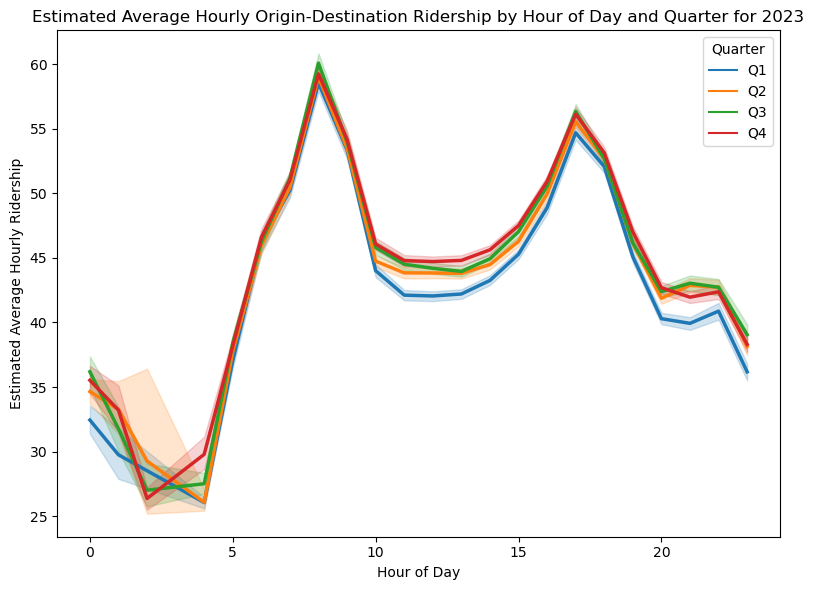

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=peak_hours,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='quarter',
    palette="tab10",
    linewidth=2.5,
    ax=ax
)

ax.get_legend().set_title('Quarter')

plt.title('Estimated Average Hourly Origin-Destination Ridership by Hour of Day and Quarter for 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout()
plt.savefig('figures/hour-quarter.png', dpi=200, bbox_inches='tight')

Figure 4: Estimated Average Hourly Origin-Destination Ridership by Hour of Day and Quarter for 2023. The figure displays the average hourly ridership across all trips and days of the week. The error bands represent the 95% confidence interval, illustrating the variability in estimated ridership. Hourly ridership values below 25 have been excluded from the display.

# Origin-Destination Pair Analysis
Identify the most frequently traveled origin-destination pairs.

In [20]:
# preview column names
con.sql("""
    SELECT *
    FROM trips
    ORDER BY estimated_average_ridership DESC
    LIMIT 1
""").df()

,year,month,day_of_week,hour_of_day,timestamp,origin_station_complex_id,origin_station_complex_name,origin_latitude,origin_longitude,destination_station_complex_id,destination_station_complex_name,destination_latitude,destination_longitude,estimated_average_ridership,origin_point,destination_point
0,2023,9,Tuesday,8,2023-09-05T08:00:00.000,610,"Grand Central-42 St (S,4,5,6,7)",40.751992,-73.977359,628,"Fulton St (A,C,J,Z,2,3,4,5)",40.710089,-74.007838,1634.1387,POINT (-73.977359 40.751992),POINT (-74.007838 40.710089)


In [21]:
# select desired columns
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    ORDER BY estimated_average_ridership DESC
    LIMIT 1
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8


Table 1. Highest Estimated Average Hourly Ridership for 2023. The highest estimated hourly ridership occurs during the 8AM hour on Tuesdays in September, traveling from Grand Central Station to Fulton Street Station.

In [22]:
df = con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

df

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1610.9985,9,Wednesday,8
2,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1562.4968,10,Wednesday,8
3,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1535.4376,10,Tuesday,8
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1480.5295,6,Tuesday,8
5,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1466.4447,7,Wednesday,8
6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.5913,6,Wednesday,8
7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.3210,5,Tuesday,8
8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.6842,8,Tuesday,8
9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.0227,11,Tuesday,8


Table 2: Top 20 Highest Estimated Average Hourly Ridership for 2023. Most of these trips are from Grand Central Station to Fulton Street Station on Tuesdays and Wednesdays at 8AM.

In [23]:
# # generate table for README
# print(df.to_markdown(index=False))

In [24]:
df = con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE day_of_week IN ('Saturday', 'Sunday')
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

df

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"161 St-Yankee Stadium (B,D,4)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",355.5740,5,Sunday,16
1,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",322.3112,12,Saturday,16
2,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",311.7885,8,Saturday,23
3,"161 St-Yankee Stadium (B,D,4)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",307.0823,8,Sunday,17
4,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",297.7674,12,Saturday,13
5,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",293.4713,8,Saturday,15
6,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),291.5284,4,Saturday,15
7,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),291.3728,4,Saturday,14
8,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",290.8654,12,Saturday,12
9,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",286.1845,5,Sunday,16


Table 3. Top 20 Highest Estimated Average Hourly Ridership on Saturdays and Sundays for 2023. A significant portion of the highest ridership figures can be attributed to Yankees games at 161st St-Yankee Stadium.

In [25]:
# print(df.to_markdown(index=False))

In [26]:
df = con.sql("""
    WITH month_trips as (
        SELECT
            DISTINCT ON (month)
            month,
            origin_station_complex_name,
            destination_station_complex_name,
            estimated_average_ridership,
            day_of_week,
            hour_of_day
        FROM trips
        ORDER BY estimated_average_ridership DESC
        LIMIT 20
    )
    
    SELECT * from month_trips ORDER BY month ASC
    
""").df()

df

,month,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,day_of_week,hour_of_day
0,1,"34 St-Penn Station (A,C,E)","5 Av/53 St (E,M)",1437.0160,Tuesday,8
1,2,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1281.4100,Wednesday,8
2,3,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1404.1932,Wednesday,8
3,4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1393.5625,Tuesday,8
4,5,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.3210,Tuesday,8
5,6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1480.5295,Tuesday,8
6,7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1466.4447,Wednesday,8
7,8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.6842,Tuesday,8
8,9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,Tuesday,8
9,10,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1562.4968,Wednesday,8


Table 4. Highest Estimated Average Hourly Ridership per Month for 2023. With the exception of January, where the route from 34th Street Penn Station to 5th Avenue/53rd Street ranks first, all other months show the highest ridership on the route from Grand Central Station to Fulton Street Station.

In [27]:
# print(df.to_markdown(index=False))

In [28]:
df = con.sql("""
    WITH week_trips AS (
        SELECT
            DISTINCT ON (day_of_week)
            day_of_week,
            origin_station_complex_name,
            destination_station_complex_name,
            estimated_average_ridership,
            month,
            hour_of_day
        FROM trips
        ORDER BY estimated_average_ridership DESC
        LIMIT 20
    )
    
    SELECT *
    FROM week_trips
    ORDER BY array_position(
        array[
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday',
            'Sunday'],
        day_of_week::VARCHAR
    )
    
""").df()

df

,day_of_week,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,hour_of_day
0,Monday,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",942.4655,11,8
1,Tuesday,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,8
2,Wednesday,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1610.9985,9,8
3,Thursday,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1367.4580,9,8
4,Friday,"161 St-Yankee Stadium (B,D,4)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",524.8005,7,21
5,Saturday,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",322.3112,12,16
6,Sunday,"161 St-Yankee Stadium (B,D,4)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",355.5740,5,16


Table 5. Highest Estimated Average Hourly Ridership per Day of Week for 2023.

In [29]:
# print(df.to_markdown(index=False))

In [30]:
df = con.sql("""
    WITH hour_trips AS (
        SELECT
            DISTINCT ON (hour_of_day)
            hour_of_day,
            origin_station_complex_name,
            destination_station_complex_name,
            estimated_average_ridership,
            month,
            day_of_week
        FROM trips
        ORDER BY estimated_average_ridership DESC
        LIMIT 24
    )
    
    SELECT * FROM hour_trips ORDER BY hour_of_day ASC
    
""").df()

df

,hour_of_day,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week
0,0,Mets-Willets Point (7),"Grand Central-42 St (S,4,5,6,7)",110.9565,9,Sunday
1,1,Mets-Willets Point (7),Flushing-Main St (7),80.0948,6,Saturday
2,2,"W 4 St-Wash Sq (A,C,E,B,D,F,M)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",36.4235,6,Saturday
3,3,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",17.2865,9,Sunday
4,4,103 St-Corona Plaza (7),"74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",48.3472,12,Friday
5,5,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",99.4730,12,Wednesday
6,6,"34 St-Penn Station (1,2,3)","Grand Central-42 St (S,4,5,6,7)",329.0864,1,Tuesday
7,7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",902.1712,10,Tuesday
8,8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday
9,9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",735.4888,10,Tuesday


Table 6. Highest Estimated Average Hourly Ridership per Hour of Day for 2023.

In [31]:
# print(df.to_markdown(index=False))

In [32]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE (hour_of_day BETWEEN 11 AND 13)
        AND day_of_week NOT IN ('Saturday', 'Sunday')
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",252.2272,12,Wednesday,12
1,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",243.7048,12,Wednesday,13
2,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",236.9817,12,Thursday,13
3,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",234.5605,12,Thursday,12
4,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",233.7728,12,Friday,13
5,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",229.6867,12,Thursday,11
6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",229.0428,10,Wednesday,11
7,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",228.6570,12,Friday,11
8,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",225.3508,12,Friday,12
9,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",219.2475,12,Tuesday,12


Table 7. Top 20 Highest Estimated Average Hourly Ridership from Monday to Friday Lunch Hours (11AM to 1PM) for 2023.

In [33]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE hour_of_day BETWEEN 1 AND 4
        AND day_of_week NOT IN ('Friday', 'Saturday', 'Sunday')
        AND origin_station_complex_name NOT IN (
            'Mets-Willets Point (7)',
            '161 St-Yankee Stadium (B,D,4)', 
            'Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)'
        )
    ORDER BY estimated_average_ridership DESC
    LIMIT 30
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,Junction Blvd (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",34.6157,11,Monday,4
1,Flushing-Main St (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",34.3985,9,Tuesday,4
2,Junction Blvd (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",33.4898,11,Tuesday,4
3,Junction Blvd (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",32.9320,12,Tuesday,4
4,Flushing-Main St (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",32.9207,11,Monday,4
5,Flushing-Main St (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",32.0135,8,Monday,4
6,Junction Blvd (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",31.9098,11,Wednesday,4
7,Flushing-Main St (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",31.5178,12,Wednesday,4
8,Flushing-Main St (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",31.2292,11,Tuesday,4
9,Junction Blvd (7),"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",30.7658,9,Tuesday,4


Table 8. Top 20 Highest Estimated Average Hourly Ridership during Weekday After Hours (excluding Yankees, Mets and Nets games) for 2023. Note: The period from 1 AM to 4 AM was selected for this analysis.

In [34]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE hour_of_day BETWEEN 1 AND 4
        AND day_of_week IN ('Saturday')
        AND origin_station_complex_name NOT IN (
            'Mets-Willets Point (7)',
            '161 St-Yankee Stadium (B,D,4)', 
            'Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)'
        )
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",54.8746,7,Saturday,1
1,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",54.4843,8,Saturday,1
2,1 Av (L),Bedford Av (L),50.6687,10,Saturday,1
3,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",49.1652,11,Saturday,1
4,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",47.4220,12,Saturday,1
5,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",46.4498,9,Saturday,1
6,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",44.2332,10,Saturday,1
7,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",Junction Blvd (7),43.6377,10,Saturday,1
8,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",43.3140,6,Saturday,1
9,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",41.7935,5,Saturday,1


Table 9. Top 20 Highest Estimated Average Hourly Ridership for Saturday After Hours (excluding Yankees, Mets and Nets games) for 2023. Note: The period from 1 AM to 4 AM was selected for this analysis.

# Case Studies
## Grand Central Station

In [35]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1610.9985,9,Wednesday,8
2,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1562.4968,10,Wednesday,8
3,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1535.4376,10,Tuesday,8
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1480.5295,6,Tuesday,8
5,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1466.4447,7,Wednesday,8
6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.5913,6,Wednesday,8
7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.3210,5,Tuesday,8
8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.6842,8,Tuesday,8
9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.0227,11,Tuesday,8


Table 10. Top 20 Highest Average Hourly Ridership Destinations from Grand Central Station in 2023. All trips are to Fulton Street and occur on Tuesdays, Wednesdays, or Thursdays at 8AM.

All of the trips are from Grand Central to Fulton Street. Let's look at unique trip combinations instead.

In [36]:
grand_central_top = con.sql("""
    SELECT
        DISTINCT ON (destination_station_complex_name)
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_top

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","34 St-Penn Station (1,2,3)",1090.7252,1,Tuesday,17
2,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",776.9200,9,Thursday,17
3,"Grand Central-42 St (S,4,5,6,7)",34 St-Hudson Yards (7),718.3783,9,Wednesday,8
4,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",578.8584,10,Tuesday,18
5,"Grand Central-42 St (S,4,5,6,7)","Brooklyn Bridge-City Hall (4,5,6)/Chambers St ...",574.0610,10,Wednesday,8
6,"Grand Central-42 St (S,4,5,6,7)","Bowling Green (4,5)",541.8905,10,Wednesday,8
7,"Grand Central-42 St (S,4,5,6,7)","86 St (4,5,6)",536.0848,6,Tuesday,17
8,"Grand Central-42 St (S,4,5,6,7)","Wall St (4,5)",462.5685,10,Wednesday,8
9,"Grand Central-42 St (S,4,5,6,7)",Vernon Blvd-Jackson Av (7),405.2100,10,Tuesday,17


Table 11. Top 20 Highest Average Hourly Ridership Destinations from Grand Central Station. Note: These are unique destinations.

In [37]:
grand_central_top['destination_full_label'] = (
    grand_central_top['destination_station_complex_name']
    + ': '
    + grand_central_top['month'].astype(str)
    + ", "
    + grand_central_top['day_of_week'].astype(str)
    + ", "
    + grand_central_top['hour_of_day'].astype(str)
)

grand_central_top.head()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day,destination_full_label
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8,"Fulton St (A,C,J,Z,2,3,4,5): 9, Tuesday, 8"
1,"Grand Central-42 St (S,4,5,6,7)","34 St-Penn Station (1,2,3)",1090.7252,1,Tuesday,17,"34 St-Penn Station (1,2,3): 1, Tuesday, 17"
2,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",776.9200,9,Thursday,17,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,..."
3,"Grand Central-42 St (S,4,5,6,7)",34 St-Hudson Yards (7),718.3783,9,Wednesday,8,"34 St-Hudson Yards (7): 9, Wednesday, 8"
4,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",578.8584,10,Tuesday,18,"14 St-Union Sq (L,N,Q,R,W,4,5,6): 10, Tuesday, 18"


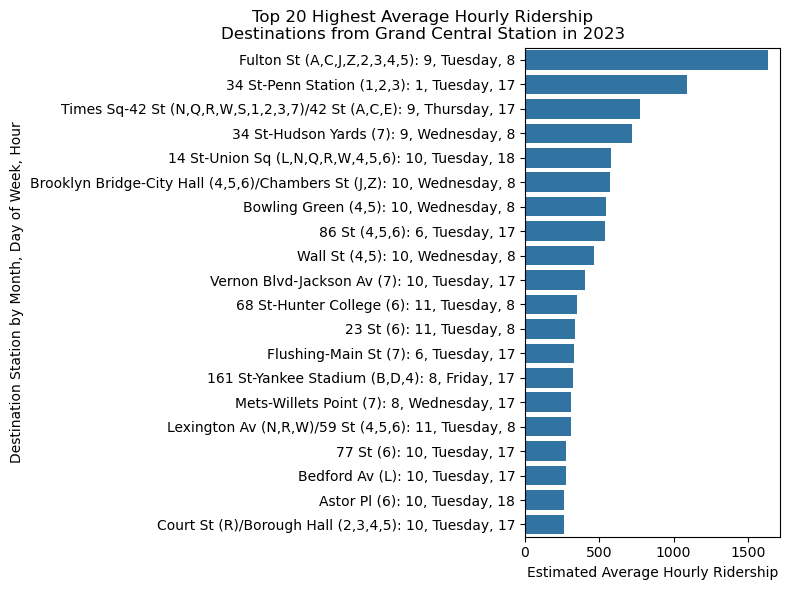

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=grand_central_top, 
    y='destination_full_label', 
    x='estimated_average_ridership', 
    color='C0',
    ax=ax
)

plt.title(
    'Top 20 Highest Average Hourly Ridership\nDestinations from Grand Central Station in 2023',
    fontsize=12, x=-.4
)
plt.xlabel('Estimated Average Hourly Ridership')
plt.ylabel('Destination Station by Month, Day of Week, Hour')

plt.tight_layout()
plt.savefig('figures/grand-central-origin.png', dpi=200, bbox_inches='tight')

Figure 5: Top 20 Highest Average Hourly Ridership Destinations from the Grand Central Station in 2023. Note: These are unique destinations.

In [39]:
grand_central_weekends = con.sql("""
    SELECT
        DISTINCT ON (destination_station_complex_name)
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE
        origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND day_of_week IN ('Saturday', 'Sunday')
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_weekends

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",297.7674,12,Saturday,13
1,"Grand Central-42 St (S,4,5,6,7)",Mets-Willets Point (7),266.2130,9,Saturday,10
2,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",261.4457,5,Sunday,12
3,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",243.7718,12,Saturday,18
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",182.5640,12,Saturday,11
5,"Grand Central-42 St (S,4,5,6,7)","Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",163.4914,12,Saturday,12
6,"Grand Central-42 St (S,4,5,6,7)","86 St (4,5,6)",157.0752,12,Saturday,12
7,"Grand Central-42 St (S,4,5,6,7)",34 St-Hudson Yards (7),146.1660,10,Saturday,9
8,"Grand Central-42 St (S,4,5,6,7)","Canal St (J,N,Q,R,W,Z,6)",138.4766,12,Saturday,11
9,"Grand Central-42 St (S,4,5,6,7)",Spring St (6),123.9372,12,Saturday,12


Table 12. Top 20 Highest Average Hourly Ridership Destinations on Saturday and Sunday from Grand Central Station. Note: These are unique destinations.

In [40]:
grand_central_weekends['destination_full_label'] = (
    grand_central_weekends['destination_station_complex_name']
    + ': '
    + grand_central_weekends['month'].astype(str)
    + ", "
    + grand_central_weekends['day_of_week'].astype(str)
    + ", "
    + grand_central_weekends['hour_of_day'].astype(str)
)

grand_central_weekends.head()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day,destination_full_label
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",297.7674,12,Saturday,13,"14 St-Union Sq (L,N,Q,R,W,4,5,6): 12, Saturday..."
1,"Grand Central-42 St (S,4,5,6,7)",Mets-Willets Point (7),266.2130,9,Saturday,10,"Mets-Willets Point (7): 9, Saturday, 10"
2,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",261.4457,5,Sunday,12,"161 St-Yankee Stadium (B,D,4): 5, Sunday, 12"
3,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",243.7718,12,Saturday,18,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,..."
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",182.5640,12,Saturday,11,"Fulton St (A,C,J,Z,2,3,4,5): 12, Saturday, 11"


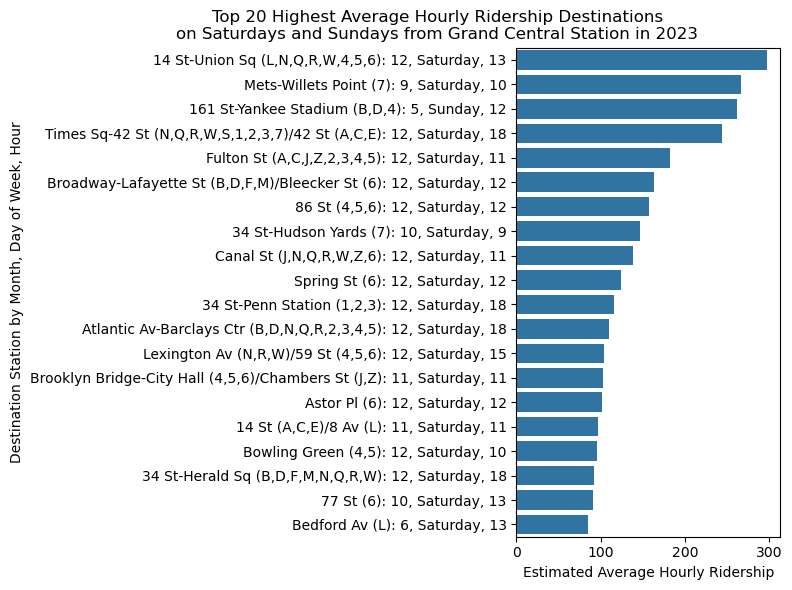

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=grand_central_weekends, 
    y='destination_full_label', 
    x='estimated_average_ridership', 
    color='C0',
    ax=ax
)

plt.title(
    'Top 20 Highest Average Hourly Ridership Destinations\non Saturdays and Sundays from Grand Central Station in 2023',
    fontsize=12, x=-.3
)
plt.xlabel('Estimated Average Hourly Ridership')
plt.ylabel('Destination Station by Month, Day of Week, Hour')

plt.tight_layout()
plt.savefig('figures/grand-central-origin-weekends.png', dpi=200, bbox_inches='tight')

Figure 6. Top 20 Highest Average Hourly Ridership Destinations on Saturdays and Sundays from Grand Central Station in 2023. Note: These are unique destinations.

In [42]:
grand_central_origin = con.sql("""
    SELECT
        DISTINCT ON (destination_station_complex_name) origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND day_of_week = 'Saturday'
        AND month = '6'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_origin

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",197.5125,6,Saturday,12
1,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",190.5900,6,Saturday,19
2,"Grand Central-42 St (S,4,5,6,7)",Mets-Willets Point (7),179.5778,6,Saturday,15
3,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",170.3873,6,Saturday,14
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",123.0657,6,Saturday,15
5,"Grand Central-42 St (S,4,5,6,7)","86 St (4,5,6)",117.3647,6,Saturday,13
6,"Grand Central-42 St (S,4,5,6,7)","Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",111.1770,6,Saturday,13
7,"Grand Central-42 St (S,4,5,6,7)","Canal St (J,N,Q,R,W,Z,6)",110.6037,6,Saturday,12
8,"Grand Central-42 St (S,4,5,6,7)",Spring St (6),89.4815,6,Saturday,12
9,"Grand Central-42 St (S,4,5,6,7)",Bedford Av (L),84.8360,6,Saturday,13


Table 13: Top 20 Highest Average Hourly Ridership Destinations on Saturdays from Grand Central Station in June 2023. Note: These are unique destinations.

In [43]:
grand_central_origin['destination_full_label'] = (
    grand_central_origin['destination_station_complex_name']
    + ': '
    + grand_central_origin['hour_of_day'].astype(str)
)

grand_central_origin.head()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day,destination_full_label
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",197.5125,6,Saturday,12,"14 St-Union Sq (L,N,Q,R,W,4,5,6): 12"
1,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",190.5900,6,Saturday,19,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,..."
2,"Grand Central-42 St (S,4,5,6,7)",Mets-Willets Point (7),179.5778,6,Saturday,15,Mets-Willets Point (7): 15
3,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",170.3873,6,Saturday,14,"161 St-Yankee Stadium (B,D,4): 14"
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",123.0657,6,Saturday,15,"Fulton St (A,C,J,Z,2,3,4,5): 15"


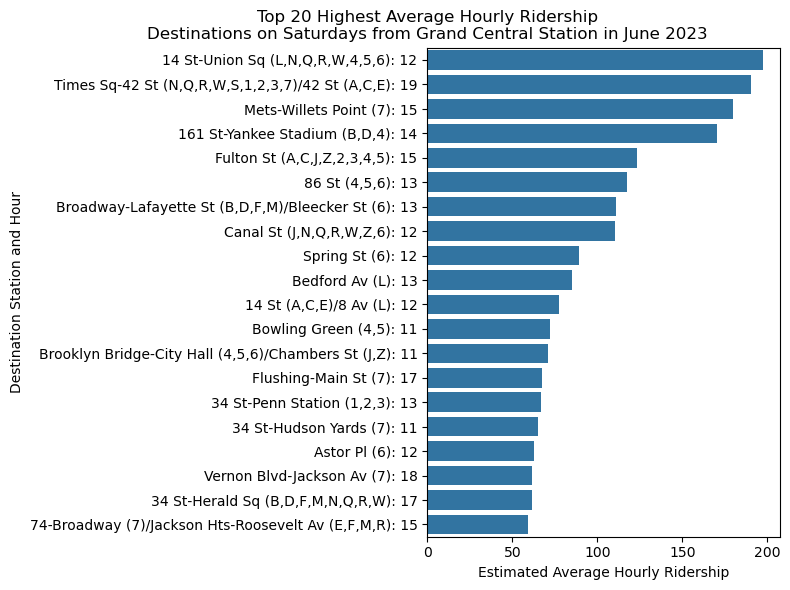

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=grand_central_origin, 
    y='destination_full_label', 
    x='estimated_average_ridership', 
    color='C0',
    ax=ax
)

plt.title(
    'Top 20 Highest Average Hourly Ridership\nDestinations on Saturdays from Grand Central Station in June 2023',
    fontsize=12, x=0
)
plt.xlabel('Estimated Average Hourly Ridership')
plt.ylabel('Destination Station and Hour')

plt.tight_layout()

Figure 7: Top 20 Highest Average Hourly Ridership Destinations on Saturdays from Grand Central Station in June 2023. Note: These are unique destinations.

In [45]:
grand_central_destination = con.sql("""
    SELECT
        DISTINCT ON (origin_station_complex_name)
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE destination_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND day_of_week = 'Saturday'
        AND month = '6'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_destination

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,Mets-Willets Point (7),"Grand Central-42 St (S,4,5,6,7)",218.6620,6,Saturday,19
1,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","Grand Central-42 St (S,4,5,6,7)",215.9083,6,Saturday,22
2,"14 St-Union Sq (L,N,Q,R,W,4,5,6)","Grand Central-42 St (S,4,5,6,7)",163.4510,6,Saturday,14
3,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",162.1230,6,Saturday,18
4,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",132.2505,6,Saturday,16
5,"86 St (4,5,6)","Grand Central-42 St (S,4,5,6,7)",123.7598,6,Saturday,13
6,"Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)","Grand Central-42 St (S,4,5,6,7)",95.5373,6,Saturday,16
7,"Canal St (J,N,Q,R,W,Z,6)","Grand Central-42 St (S,4,5,6,7)",92.4135,6,Saturday,17
8,Spring St (6),"Grand Central-42 St (S,4,5,6,7)",89.4755,6,Saturday,16
9,"Lexington Av (N,R,W)/59 St (4,5,6)","Grand Central-42 St (S,4,5,6,7)",84.1985,6,Saturday,15


Table 14: Top 20 Highest Average Hourly Ridership Origin Stations on Saturdays to Grand Central Station in June 2023. Note: These are unique origin stations.

In [46]:
grand_central_destination['origin_full_label'] = (
    grand_central_destination['origin_station_complex_name']
    + ': '
    + grand_central_destination['hour_of_day'].astype(str)
)

grand_central_destination.head()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day,origin_full_label
0,Mets-Willets Point (7),"Grand Central-42 St (S,4,5,6,7)",218.6620,6,Saturday,19,Mets-Willets Point (7): 19
1,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","Grand Central-42 St (S,4,5,6,7)",215.9083,6,Saturday,22,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,..."
2,"14 St-Union Sq (L,N,Q,R,W,4,5,6)","Grand Central-42 St (S,4,5,6,7)",163.4510,6,Saturday,14,"14 St-Union Sq (L,N,Q,R,W,4,5,6): 14"
3,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",162.1230,6,Saturday,18,"161 St-Yankee Stadium (B,D,4): 18"
4,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",132.2505,6,Saturday,16,"Fulton St (A,C,J,Z,2,3,4,5): 16"


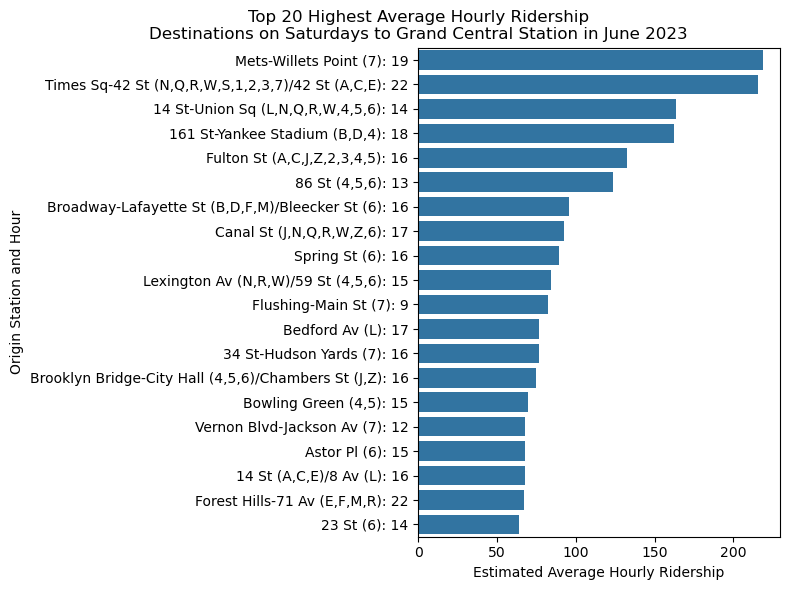

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=grand_central_destination, 
    y='origin_full_label', 
    x='estimated_average_ridership', 
    color='C0',
    ax=ax
)

plt.title(
    'Top 20 Highest Average Hourly Ridership\nDestinations on Saturdays to Grand Central Station in June 2023',
    fontsize=12, x=-.0
)
plt.xlabel('Estimated Average Hourly Ridership')
plt.ylabel('Origin Station and Hour')

plt.tight_layout()

Figure 8: Top 20 Highest Average Hourly Ridership Origin Stations on Saturdays to Grand Central Station in June 2023. Note: These are unique origin stations.

In [48]:
grand_central_fulton = con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE destination_station_complex_name = 'Fulton St (A,C,J,Z,2,3,4,5)'
        AND origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND month = 6
    ORDER BY estimated_average_ridership DESC
""").df()

grand_central_fulton

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1480.5295,6,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.5913,6,Wednesday,8
2,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1168.8444,6,Thursday,8
3,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",852.8152,6,Tuesday,7
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",780.9475,6,Wednesday,7
...,...,...,...,...,...,...
162,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",0.3200,6,Sunday,3
163,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",0.3147,6,Wednesday,4
164,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",0.3027,6,Monday,4
165,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",0.2845,6,Wednesday,3


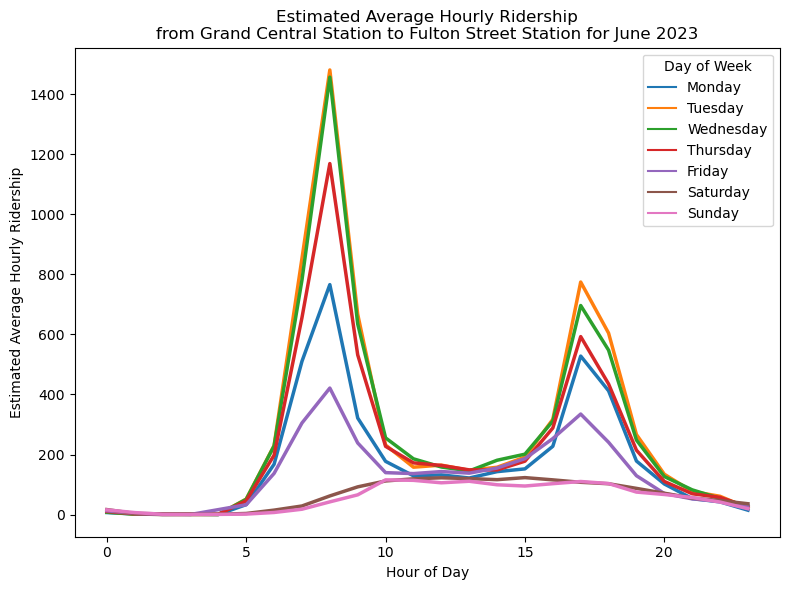

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))

hue_order = [
    'Monday', 'Tuesday',
    'Wednesday', 'Thursday','Friday',
    'Saturday', 'Sunday'
]

sns.lineplot(
    data=grand_central_fulton,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='day_of_week',
    palette="tab10",
    linewidth=2.5,
    hue_order=hue_order,
    ax=ax
)

ax.get_legend().set_title('Day of Week')

plt.title('Estimated Average Hourly Ridership\nfrom Grand Central Station to Fulton Street Station for June 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout()   
plt.savefig('figures/fulton-street-june.png', dpi=200, bbox_inches='tight')

Figure 9: Estimated Average Hourly Ridership from Grand Central Station to Fulton Street Station for June 2023.

## Yankee Stadium Station

In [50]:
yankee_stadium = con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        month,
        day_of_week,
        hour_of_day,
        estimated_average_ridership
    FROM trips
    WHERE destination_station_complex_name = '161 St-Yankee Stadium (B,D,4)'
        AND origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND month = 6   
    ORDER BY estimated_average_ridership DESC
""").df()

yankee_stadium

,origin_station_complex_name,destination_station_complex_name,month,day_of_week,hour_of_day,estimated_average_ridership
0,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",6,Tuesday,17,273.7580
1,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",6,Tuesday,18,269.2013
2,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",6,Friday,17,232.8200
3,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",6,Friday,18,187.9974
4,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",6,Thursday,18,181.7978
...,...,...,...,...,...,...
162,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",6,Wednesday,4,0.3147
163,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",6,Saturday,5,0.3113
164,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",6,Sunday,3,0.2813
165,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",6,Thursday,4,0.2250


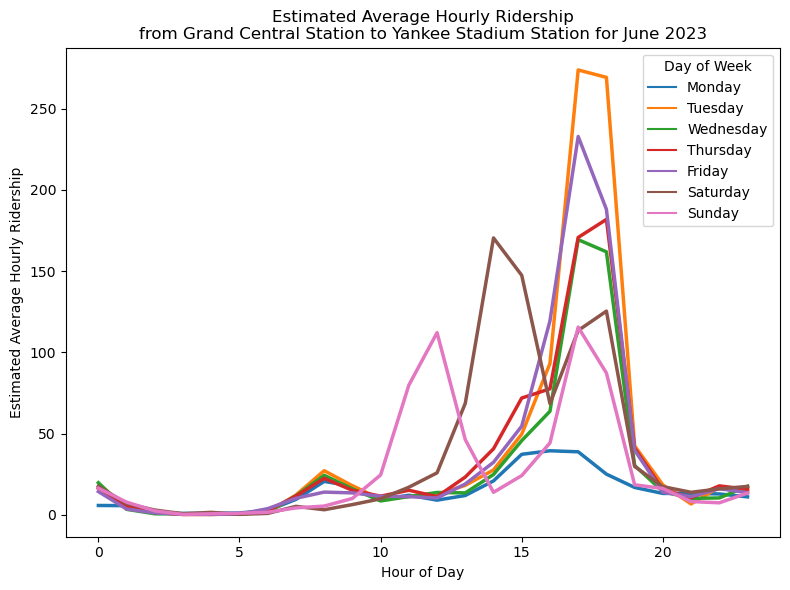

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

hue_order = [
    'Monday', 'Tuesday',
    'Wednesday', 'Thursday','Friday',
    'Saturday', 'Sunday'
]

sns.lineplot(
    data=yankee_stadium,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='day_of_week',
    palette="tab10",
    linewidth=2.5,
    hue_order=hue_order,
    ax=ax
)

ax.get_legend().set_title('Day of Week')

plt.title('Estimated Average Hourly Ridership\nfrom Grand Central Station to Yankee Stadium Station for June 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout() 
plt.savefig('figures/yankees-june.png', dpi=200, bbox_inches='tight')

Figure 10: Estimated Average Hourly Ridership from Grand Central Station to Yakee Stadium Stadium for June 2023.

## Bedford Av Station (Williamsburg, BK)

In [52]:
williamsburg = con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        month,
        day_of_week,
        hour_of_day,
        estimated_average_ridership
    FROM trips
    WHERE destination_station_complex_name = 'Bedford Av (L)'
        AND origin_station_complex_name = '14 St-Union Sq (L,N,Q,R,W,4,5,6)'
        AND month = 6   
    ORDER BY estimated_average_ridership DESC
""").df()

williamsburg

,origin_station_complex_name,destination_station_complex_name,month,day_of_week,hour_of_day,estimated_average_ridership
0,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),6,Tuesday,18,288.8885
1,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),6,Wednesday,18,258.4450
2,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),6,Tuesday,17,256.7370
3,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),6,Thursday,18,233.4730
4,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),6,Wednesday,17,224.5135
...,...,...,...,...,...,...
162,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),6,Monday,3,0.2750
163,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),6,Wednesday,4,0.2693
164,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),6,Friday,5,0.2316
165,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),6,Friday,4,0.2000


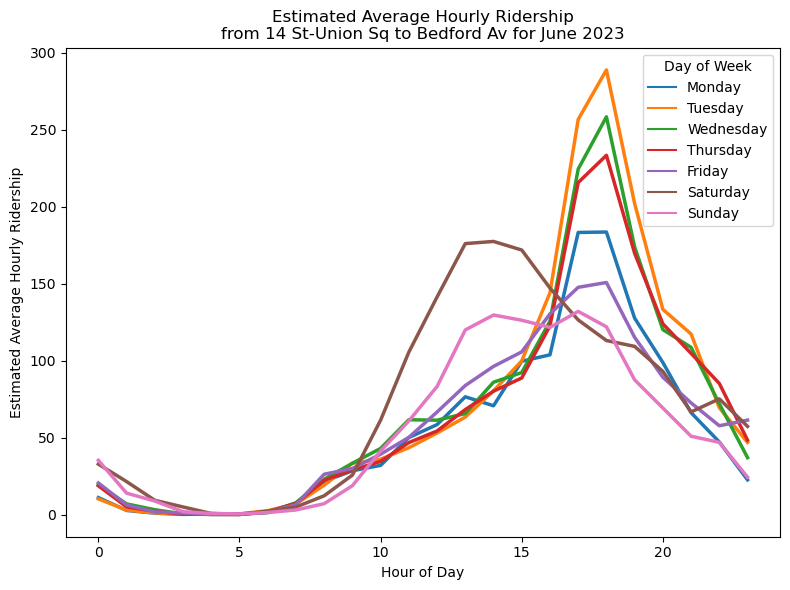

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))

hue_order = [
    'Monday', 'Tuesday',
    'Wednesday', 'Thursday','Friday',
    'Saturday', 'Sunday'
]

sns.lineplot(
    data=williamsburg,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='day_of_week',
    palette="tab10",
    linewidth=2.5,
    hue_order=hue_order,
    ax=ax
)

ax.get_legend().set_title('Day of Week')

plt.title('Estimated Average Hourly Ridership\nfrom 14 St-Union Sq to Bedford Av for June 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout() 
plt.savefig('figures/williamsburg-june.png', dpi=200, bbox_inches='tight')

Figure 11: Estimated Average Hourly Ridership from 14 St-Union Sq to Bedford Av Williamsburg for June 2023.

In [54]:
# close DuckDB connection
con.close()